<a href="https://colab.research.google.com/github/ritikraj660/Speaker-recognition/blob/master/Speaker_Classification_mfcc%26gfcc_v1_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing Packages:

In [0]:
#!pip install --upgrade tensorflow-gpu

In [0]:
!pip install soundfile
!pip install spafe

In [0]:
import tensorflow
tensorflow.test.gpu_device_name() 

'/device:GPU:0'

# Import Data from Drive :

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link = 'https://drive.google.com/file/d/1qxZWgx3vttou1HSvyxRDiOYWnaLAK9fj/view?usp=sharing'
#fluff, id = link.split('=')
id = '1qxZWgx3vttou1HSvyxRDiOYWnaLAK9fj'
print (id) 

1qxZWgx3vttou1HSvyxRDiOYWnaLAK9fj


In [0]:
import pandas as pd
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('LibriSpeech.zip')  

# Extracting Data from (.)rar

In [0]:
!pip install patool

In [0]:
import os
os.listdir()

['.config', 'adc.json', 'LibriSpeech.zip', 'sample_data']

In [0]:
%%time
import patoolib
patoolib.extract_archive("LibriSpeech.zip")

patool: Extracting LibriSpeech.zip ...
patool: running /usr/bin/7z x -o./Unpack_b_4evn2t -- LibriSpeech.zip
patool: ... LibriSpeech.zip extracted to `LibriSpeech'.
CPU times: user 15.5 ms, sys: 16.2 ms, total: 31.7 ms
Wall time: 662 ms


# Audio Data Preprocessing :

In [0]:
import librosa
import soundfile
import tqdm
from scipy.io import wavfile
import glob
import os,pickle
import numpy as np
from spafe.features.mfcc import mfcc, imfcc
import csv
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow.python.keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD

Using TensorFlow backend.


In [0]:
def norm_(x,mean = False):
    if mean == True:
        return (x - np.mean(x)) / (np.max(x) - np.min(x)) #normalization                             
    else:
        return (x-np.mean(x)/np.std(x)) #standardization

def zero_handling(x):
    """
    handle the issue with zero values if they are exposed to become an argument
    for any log function.

    Returns:
        vector with zeros substituted with epsilon values.
    """
    return np.where(x == float(0), np.finfo(float).eps, x)

In [0]:
from spafe.features.lpc import lpc
from spafe.features.gfcc import gfcc

def mfcc_(sig,fs,cep):
    mfccs  = mfcc(sig, fs=fs, num_ceps=cep, pre_emph=1, pre_emph_coeff=0.95, 
              win_len=0.025, win_hop=0.01, win_type='hamming', nfilts=26, 
              nfft=512, low_freq=None, high_freq=None, scale='constant', 
              dct_type=2, use_energy=False, lifter=22)
    #print(fs)
    return mfccs

def gfcc_(sig,fs,cep):
  gfccs = gfcc(sig, fs=fs, num_ceps=cep, pre_emph=0, 
             pre_emph_coeff=0.97, win_len=0.025, win_hop=0.01, win_type='hamming', 
             nfilts=26, nfft=512, low_freq=None, high_freq=None, scale='constant', 
             dct_type=2, use_energy=False, lifter=22, normalize=1)
  return gfccs

# combine mfcc and gfcc ceptral features
def gfcc_mfcc(y,sr,cep):
    g = gfcc_(y,sr,cep)
    m = mfcc_(y,sr,cep)
    if g.shape[0] != m.shape[0]:
        pass
    result = np.zeros([g.shape[1]+m.shape[1]])
    for i in range(g.shape[0]):
        merge = np.concatenate((m[i],g[i]))
        result = np.vstack((result,merge))
    return result[1:,:]

In [0]:
def label(user,total): # its creating lable for splited audio data
    k_train = []
    for i in range(total):
        k_train.append(user)
    y_train=np.array(k_train).T
    return y_train

In [0]:
from pathlib import Path
len_audio = 148
def s2c(mfcc=False,gmfcc=False,gfcc=False,cep=20):
    x,y=[],[]
    if gmfcc==True:
      ceps=cep+cep
    else:
      ceps=cep  
    data = np.empty([1,len_audio,ceps])
    data_label = np.asarray([])
    count =0  # E:\dataset\LibriSpeech\dev-clean
    #for file in tqdm(glob.iglob('/LibriSpeech/test-clean//**/*.flac', recursive=True)):
    for file in tqdm(Path('LibriSpeech/dev-clean').glob('**/*.flac')):
        file_name=os.path.basename(file)
        user = file_name.split("-")[0]
        #print(f)
        with soundfile.SoundFile(file) as sound_file:
                signal = sound_file.read(dtype="float32")
                sr=sound_file.samplerate
        signal = norm_(signal,mean = False)
        signal = zero_handling(signal)
        
        if mfcc:
            feature = mfcc_(signal,sr,cep)
            #print(feature.shape[0])
        if gmfcc:
            feature = gfcc_mfcc(signal,sr,cep)
            ceps = feature.shape[1]   
        #if feature.shape[0]>256:
        if gfcc:
            feature = gfcc_(signal,sr,cep)

        quotient = int(feature.shape[0]/len_audio)
        end_index = feature.shape[0]-(feature.shape[0]%len_audio)
        r = feature[0:end_index,:]
        re_data = np.reshape(r,(-1,len_audio,ceps)) #b = np.reshape(a, (8, 3, -1))
        data=np.concatenate((data,re_data),axis=0)
        
        re_label = label(user,quotient)
        data_label = np.concatenate((data_label,re_label),axis=0)
    return data[1:,:,:],data_label

In [0]:
%%time
def write_(x,y):
    with open('mfcc_data.csv', 'a') as mfcc_dataFile:
        writer = csv.writer(mfcc_dataFile)
        writer.writerows(x)
    mfcc_dataFile.close()
    with open('mfcc_label.csv', 'a') as mfcc_labelFile:
        writer = csv.writer(mfcc_labelFile)
        writer.writerows(y)
    mfcc_labelFile.close()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


In [0]:
%%time
x,y = s2c(mfcc=False,gmfcc=True,gfcc=False,cep=20)

#write_(x,y)
print(x.shape,y.shape)


u = np.unique(y)
num_classes = len(u)
#print(u)
d = dict()
for enu,key in enumerate(u,0):
    d[key]=enu
print(d)
for i in range(len(y)):
    y[i] = d[y[i]]

661it [00:59, 11.11it/s]

(2950, 148, 40) (2950,)
{'1272': 0, '1462': 1, '1673': 2, '174': 3, '1919': 4, '251': 5, '422': 6, '652': 7, '777': 8, '84': 9}
CPU times: user 1min 3s, sys: 46.6 s, total: 1min 50s
Wall time: 59.5 s


In [0]:
X  = x.reshape(x.shape[0],x.shape[1],x.shape[2],1)
print(X.shape)
import keras

y_binary = keras.utils.to_categorical(y, num_classes = 10)
#y_binary = np.asarray(list(map(int,y)))
print(y_binary)

x_train, x_test, y_train, y_test = train_test_split(X,y_binary ,test_size=0.20, shuffle= True)

print("Training shape: {0}, Training label shape : {1}".format(x_train.shape,y_train.shape))
print("Training shape: {0}, Training label shape : {1}".format(x_test.shape,y_test.shape))

(2950, 148, 40, 1)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]
Training shape: (2360, 148, 40, 1), Training label shape : (2360, 10)
Training shape: (590, 148, 40, 1), Training label shape : (590, 10)


# Plotting plot :



1.   **accuracy_plot()** : This function plot graph between train accuracy vs validation/test accuracy
2.   **loss_plot():** This function plot graph between train loss vs validation loss



In [0]:
import keras
from matplotlib import pyplot as plt
def accuracy_plot(history):
    #plt.figure(figsize=(12,8))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.grid()
    plt.show()

def loss_plot(history):
    #plt.figure(figsize=(12,8))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.grid()
    plt.show()

In [0]:
"""
def audioLengthInSecond(sr,m,t_s):#t_s will gives time in second[1 for 1sec, 2 for 2sec]
    t = round(sr/512) # Number of frames in one second
    totalFrame = t*t_s # Number of frames in one second * time(second)
    t1 = round(m.shape[0]/totalFrame) # total_audio_time/ t_s
    #print(time_in_sec)
    #print(" Actual audio length in second :",t1,"\n","Number of frames in one second :",t)
    j=0
    total = totalFrame*m.shape[1]
    result = np.zeros([1,total])
    #print(result.shape)
    for i in range(t1):
            temp = m[j:j+totalFrame,:].reshape(1,-1)
            diff = total-temp.shape[1]
            if round(total*0.3)>diff: # if more 30% padding need done then we will not add that audio file
                #print(diff)
                if diff!=0:
                    temp = np.concatenate((temp[0,:],temp[0,diff:diff+diff])).reshape(1,-1)
                #print("temp",temp.shape)
                result = np.concatenate((result,temp))
                j += totalFrame
            else:
                pass
    return result[1:,:]
t_s=2
r = audioLengthInSecond(sr,m,t_s)
print(r.shape)
"""

# Creating CNN Architecture :

In [0]:
%tensorflow_version 2.x
import tensorflow 
device_name = tensorflow.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
from tensorflow.keras.optimizers import SGD
from tensorflow.python.keras.callbacks import ModelCheckpoint
"""
def CNN_model_training(x_train,y_train,x_text,y_test,output_size,epoch = 500,batch_sizes = 16):

  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(x.shape[1],x.shape[2],1)))

  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Conv2D(64, (3, 3), activation='relu'))

  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.5))
  model.add(Flatten())

  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.5))

  model.add(Dense(output_size, activation='softmax'))
  opt = SGD(lr=0.001, momentum=0.9)                        #optimizer=keras.optimizers.Adam()
  model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy'])
  print(model.summary())
  
  # Saving the model that performed the best on the validation set
  checkpoint = ModelCheckpoint(filepath='Model.v_2.hdf5', save_best_only=True, verbose=0)



  history = model.fit(x_train, y_train, batch_size = batch_sizes, epochs=epoch, 
                      validation_data=(x_test, y_test), verbose=0, callbacks=[checkpoint])
  accuracy_plot(history)
  loss_plot(history)                    
"""

In [0]:
from tensorflow.keras.optimizers import SGD

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(x.shape[1],x.shape[2],1)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3), activation='relu'))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(10, activation='softmax'))
opt = SGD(lr=0.001, momentum=0.9)                        #optimizer=keras.optimizers.Adam()
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy'])
print(model.summary())




Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 146, 38, 32)       320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 144, 36, 32)       9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 72, 18, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 72, 18, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 70, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 68, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 7, 64)         0

In [0]:
%%time
epoch = 200
batch_sizes = 16
from tensorflow.python.keras.callbacks import ModelCheckpoint
# Saving the model that performed the best on the validation set
checkpoint = ModelCheckpoint(filepath='Model.v_2.hdf5', save_best_only=True, verbose=0)



history = model.fit(x_train, y_train, batch_size = batch_sizes, epochs=epoch, 
                    validation_data=(x_test, y_test), verbose=1, callbacks=[checkpoint])

In [0]:
#Loading the model that performed the best on the validation set
model.load_weights('Model.v_2.hdf5')

# Testing the model on the Test data
(loss, accuracy) = model.evaluate(x_test, y_test, batch_size=16, verbose=1)

print('Accuracy on test data: {:.2f}%'.format(accuracy * 100))

37/37 [==============================] - 0s 7ms/step - loss: 0.0973 - accuracy: 0.9746
Accuracy on test data: 97.46%


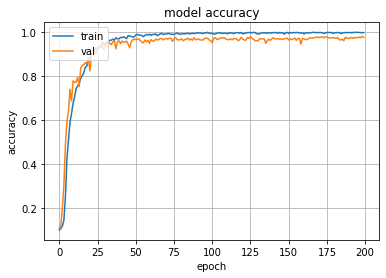

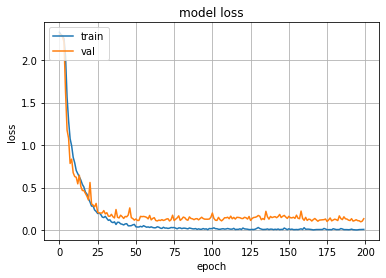

In [0]:
accuracy_plot(history)
loss_plot(history)

In [0]:
#@title
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [0]:
#@title
yhat_probs = model.predict(x_test, verbose=0)  #np.argmax(model.predict(x), axis=-1)
# predict crisp classes for test set
yhat_classes = model.predict_classes(x_test, verbose=0)
print(yhat_probs.shape,yhat_classes.shape)

In [0]:
#@title
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
#yhat_classes = yhat_classes[:, 0]

In [0]:
#@title
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)

In [0]:
#@title
# kappa
kappa = cohen_kappa_score(y_test, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, yhat_probs)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)

In [0]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)

# VGG16

In [0]:
"""model1 = Sequential()
model1.add(Conv2D(input_shape=(x.shape[1],x.shape[2],1),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model1.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))

model1.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model1.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model1.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))

model1.add(MaxPooling2D(pool_size=(2,2),strides=(1,1)))

model1.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model1.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model1.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))

model1.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model1.add(Conv2D(filters=512, kernel_size=(3,3), pāadding="same", activation="relu"))
model1.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model1.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))

model1.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model1.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model1.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model1.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))

model1.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model1.add(Flatten())
model1.add(Dense(units=128,activation="relu"))
model1.add(Dense(units=128,activation="relu"))
model1.add(Dense(units=40, activation="softmax"))
print(model1.summary())
model1.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
"""

In [0]:
"""%%time
from keras.callbacks import ModelCheckpoint
# Saving the model that performed the best on the validation set
checkpoint = ModelCheckpoint(filepath='Model.v_2.hdf5', save_best_only=True, verbose=0)

# Training the model for 40 epochs
history = model1.fit(x_train, y_train, batch_size=32, epochs=200, 
                    validation_data=(x_test, y_test), verbose=1, callbacks=[checkpoint])"""

In [0]:
"""# Loading the model that performed the best on the validation set
model1.load_weights('Model.v_2.hdf5')

# Testing the model on the Test data
(loss, accuracy) = model1.evaluate(x_test, y_test, batch_size=128, verbose=1)

print('Accuracy on test data: {:.2f}%'.format(accuracy * 100))"""